In [1]:
import sys
import os
import glob
from typing import Union, Callable
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from tqdm import tqdm

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

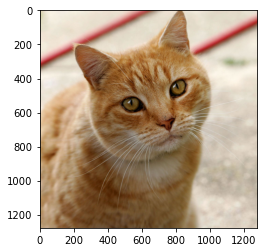

In [2]:
img = Image.open('./transformer_data/Cat03.jpg')
plt.imshow(img)

# resize to imagenet size 
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim

In [3]:
patch_size = 16
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

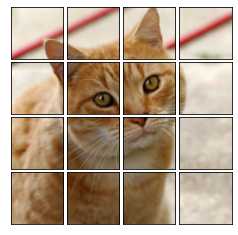

In [4]:
no_patches = 4
plot_patch_size = x.size(-1) // no_patches

plot_patches = rearrange(x, 'b c (h s1) (w s2) -> b c (h w) s1 s2', s1=plot_patch_size, s2=plot_patch_size)

plt.figure(figsize=(4,4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.025, hspace=0.05)

for i in range(no_patches**2):
    #for j in range(no_patches):
    ax = plt.subplot(gs[i])
    ax.imshow(rearrange(plot_patches[0,:,i], 'c h w -> h w c'))
    ax.set_yticks([])
    ax.set_xticks([])

plt.show()

In [5]:
class Embeddings(nn.Module):
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 emb_size: int = 768,
                 img_size: int = 224,
                 # patch_embedding: nn.Module = patch_embedding_conv,
                 dropout: float = 0.):
        super().__init__()
        self.patch_embeddings = nn.Conv2d(in_channels=in_channels,
                                         out_channels=emb_size,
                                         kernel_size=patch_size,
                                         stride=patch_size)
        self.pos_embeddings = nn.Parameter(torch.zeros(1, (img_size // patch_size)**2 + 1, emb_size))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        self.dropout = dropout

    def forward(self, x: Tensor) -> Tensor:
        cls_token = repeat(self.cls_token, '() n e -> b n e', b=x.size(0))

        x = self.patch_embeddings(x)
        x = rearrange(x, 'b e (h) (w) -> b (h w) e')
        x = torch.cat([cls_token, x], dim=1)

        embeddings = x + self.pos_embeddings
        return F.dropout(embeddings, p =self.dropout)

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int, n_heads: int, dropout: float = 0.):
        super().__init__()
        self.emb_size = emb_size
        self.n_heads = n_heads

        self.q, self.k, self.v = [nn.Linear(emb_size, emb_size) for _ in range(3)]

        self.out = nn.Linear(emb_size, emb_size)
        self.dropout = dropout

    def forward(self, x: Tensor):
        queries, keys, values = [rearrange(m(x), 'b n (h d) -> b h n d', h=self.n_heads) for m in [self.q, self.k, self.v]]

        score = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        probs = F.softmax(score / (self.emb_size / self.n_heads)**.5, dim=-1)

        context = torch.einsum('bhal, bhlv -> bhav ', F.dropout(probs, p=self.dropout), values)
        context = rearrange(context, "b h n d -> b n (h d)")

        attn = F.dropout(self.out(context), p=self.dropout)

        return attn, probs

In [7]:
class MLP(nn.Module):
    def __init__(self, emb_size: int, mlp_dim: int, dropout: float = 0.):
        super().__init__()
        self.fc1 = nn.Linear(emb_size, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, emb_size)
        self.dropout = dropout

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = F.dropout(F.gelu(self.fc1(x)), p=self.dropout)
        x = F.dropout(self.fc2(x), p=self.dropout)
        return x

In [8]:
class EncoderBlock(nn.Module):
    def __init__(self, emb_size: int, mlp_dim: int, n_heads: int,
                 mlp_dropout: float = 0., attn_dropout: float = 0.):
        super().__init__()
        self.emb_size = emb_size
        self.attn_norm = nn.LayerNorm(emb_size, eps=1e-6)
        self.ffn_norm = nn.LayerNorm(emb_size, eps=1e-6)
        self.ffn = MLP(emb_size=emb_size,
                       mlp_dim=mlp_dim,
                       dropout=mlp_dropout)
        self.attn = MultiHeadAttention(emb_size=emb_size,
                                       n_heads=n_heads,
                                       dropout=attn_dropout)

    def forward(self, x: Tensor) -> (Tensor, [Tensor]):
        _x, attn_probs = self.attn(self.attn_norm(x))
        x = _x + x
        x = x + self.ffn(self.ffn_norm(x))
        return x, attn_probs

In [9]:
class Encoder(nn.Module):

    def __init__(self, emb_size: int, depth: int, n_heads: int, mlp_dim: int,
                 attn_dropout: float = 0., mlp_dropout: float = 0.):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderBlock(emb_size=emb_size, mlp_dim=mlp_dim, n_heads=n_heads,
                         mlp_dropout=mlp_dropout, attn_dropout=attn_dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(emb_size, eps=1e-6)

    def forward(self, x: Tensor) -> (Tensor, [Tensor]):
        attn_probs = []
        for l in self.layers:
            x, attn_prob = l(x)
            attn_probs.append(attn_prob.detach())
        encoded = self.norm(x)
        return encoded, attn_probs

In [10]:
class ViT(nn.Module):

    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 img_size: int = 224,
                 n_classes: int = 1000,
                 emb_size: int = 768,
                 depth: int = 12,
                 n_heads: int = 12,
                 mlp_dim: int = 4 * 768,
                 attn_dropout: float = 0.,
                 mlp_dropout: float = 0.):
        super().__init__()
        self.embeddings = Embeddings(in_channels=in_channels, patch_size=patch_size,
                                     emb_size=emb_size, img_size=img_size, dropout=mlp_dropout)
        self.encoder = Encoder(emb_size=emb_size, depth=depth, n_heads=n_heads, mlp_dim=mlp_dim,
                               attn_dropout=attn_dropout, mlp_dropout=mlp_dropout)
        self.classification_head = nn.Linear(emb_size, n_classes)

    def forward(self, x: Tensor) -> (Tensor, [Tensor]):
        embedding_output = self.embeddings(x)
        encoded, attn_probs = self.encoder(embedding_output)
        logits = self.classification_head(encoded[:, 0])
        return logits, attn_probs

In [11]:
class CatsVsDogs(Dataset):
    def __init__(self, path: str, transform: object = None):
        self.X, self.y = [], []
        for sub_dir in os.listdir(path):
            fnames = glob.glob(os.path.join(path, sub_dir, '*.jpg'))
            labels = [0] if sub_dir == 'cats' else [1]
            self.y += labels * len(fnames)
            self.X += fnames
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx: int):
        img = Image.open(self.X[idx])
        label = self.y[idx]
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, label

In [12]:
IN_CHANNELS = 3
IMG_SIZE = 224
N_CLASSES = 2
# needed to load weights pretrained on imagenet
N_CLASSES_INIT = 1000
WEIGHT_PATH = './transformer_data/vit_weights.pt'

DATA_PATH = '../../data/cats-vs-dogs'
VALIDATION_SPLIT = 0.2

BATCH_SIZE = 64
N_EPOCHS = 1

LR = 3e-5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

PATCH_SIZE = 16
EMB_SIZE = 768
DEPTH = 12
N_HEADS = 12
MLP_DIM = 4 * EMB_SIZE
ATTN_DROPOUT = 0.
MLP_DROPOUT = 0.1

In [13]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [14]:
train_set = CatsVsDogs(DATA_PATH + '/train', transform=transform)
test_set = CatsVsDogs(DATA_PATH + '/test', transform=transform)

indices = list(range(len(train_set)))
split = int(np.floor(VALIDATION_SPLIT * len(train_set)))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
                          sampler=train_sampler)
valid_loader = DataLoader(train_set, batch_size=BATCH_SIZE,
                          sampler=valid_sampler)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
def calc_accuracy(pred: Tensor, label: Tensor) -> float:
    return (pred.argmax(dim=1) == label).float().mean().item()

def train_epoch(model: nn.Module, optim: torch.optim.Optimizer, criterion: Union[Callable, nn.Module], 
                data_loader: DataLoader, device: str = 'cuda') -> [[float]]:
    accs = []
    pbar = tqdm(data_loader)
    for X, y in pbar:
        optim.zero_grad()
        X, y = X.to(device), y.to(device)
        
        pred, _ = model(X)
        loss = criterion(pred, y)
        
        loss.backward()
        optim.step()
        
        acc = calc_accuracy(pred, y)
        accs.append(acc)
        
        pbar.set_description(f'Acc: {acc} | Loss: {loss.item()}')
    return np.mean(accs)

def validate(model: nn.Module, criterion: Union[Callable, nn.Module], 
             data_loader: DataLoader, device: str = 'cuda') -> [[float]]:
    accs = []
    pbar = tqdm(data_loader)
    with torch.no_grad():
        for X, y in pbar:
            X, y = X.to(device), y.to(device)

            pred, attn_probs = model(X)
            loss = criterion(pred, y)

            acc = calc_accuracy(pred, y)
            accs.append(acc)

            pbar.set_description(f'Acc: {acc} | Loss: {loss.item()}')
    return np.mean(accs)

In [16]:
vit = ViT(
    in_channels=IN_CHANNELS,
    patch_size=PATCH_SIZE,
    img_size=IMG_SIZE,
    n_classes=N_CLASSES_INIT,
    emb_size=EMB_SIZE,
    depth=DEPTH,
    n_heads=N_HEADS,
    mlp_dim=MLP_DIM,
    attn_dropout=ATTN_DROPOUT,
    mlp_dropout=MLP_DROPOUT
).to(DEVICE)
vit.load_state_dict(torch.load(WEIGHT_PATH))

vit.classification_head = nn.Linear(vit.classification_head.weight.size(1), N_CLASSES).to(DEVICE)

optim = torch.optim.Adam(vit.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [17]:
for e in range(N_EPOCHS):
    train_acc = train_epoch(vit, optim, criterion, train_loader, DEVICE)
    valid_acc = validate(vit, criterion, valid_loader, DEVICE)
    
    print(f'Train Acc: {train_acc} | Valid Acc: {valid_acc}')
    sys.stdout.flush()

Acc: 0.96875 | Loss: 0.03713130205869675: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s] 
Acc: 0.984375 | Loss: 0.08159852772951126: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s] 

Train Acc: 0.9865625 | Valid Acc: 0.985625


In [18]:
test_acc = validate(vit, criterion, test_loader, DEVICE)
print(f'Test Acc: {test_acc}')

Acc: 1.0 | Loss: 0.00356136541813612: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]      

Test Acc: 0.9892578125
